In [140]:
library(tidyverse)
library(repr)
library(readxl)
library(GGally)
library(tidymodels)
options(repr.matrix.max.rows = 10)
set.seed(1212)
message = FALSE

# Classifying a User's Knowledge Based On Domain Dependant Data

## Introduction

As the world grows increasingly digitalized, more and more things thought of as only possible face to face are being brought over into the online space. Especially in the recent decade, online learning has been seeing exponential expansion. However, how can an online web-course possibly compare to an in-person teacher, capable of catering to each individual student to fit his or her needs? The solution calls for a **web-based adaptive learning environment**, capable of personalizing it's content to every user's individual needs. The goal here is to create a learning environment that can suit each learner's needs based on their knowledge level for each subject.

The "how?" leads to our question: **What aspects of learning can predict a user's knowledge level most accurately, and how accurately can we predict a user's knowledge level using these predictors?**

#### Our Dataset

The dataset we will be using is the "User Knowledge Modeling Data Set", gathered by Hamdi Tolga Kahraman from students taking the web based Adaptive Educational Electric Course (AEEC) in Gazi University in the 2009 semester. 

The predictors STG, SCG, STR, LPR, and PEG represent domain dependant information on a user. **Domain dependant information is dynamic data that represents the knowledge level of the student in certain areas.** These predictors are defined as:   <br />
- **STG**: The degree of study time for goal subject/concept, information such as readings done, elapsed time in related pages, pages clicked, etc   <br />
- **SCG**: The degree of repetition for goal subject/concept, information such as solving problems/exercises, keystrokes and clicks, feedback from user   <br />
- **STR**: Same as STG but concerning related required subjects   <br />
- **LPR**: The exam performance of user for related subjects   <br />
- **PEG**: The exam performance of user for goal subject/concept  <br />
    
These are standardized values between 0 and 1, and are generated using a rule based table to convert all the information they are comprised of into a single value we can work with.  <br />

Lastly, **UNS** represents the knowledge level of a user for the goal subject/concept. It is one of "very low", "low", "middle", and "high".

**This code below loads the dataset and reads the first 10 lines of the testing data.**

In [141]:
#Loading data into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi.xls")

#Reads testing data
testing_data <- read_excel("Data_User_Modeling_Dataset_Hamdi.xls", sheet = 3) %>%
    select(STG:UNS)

testing_data[testing_data == "Very Low"] <- "very_low"
testing_data[testing_data == "High"] <- "high"
testing_data[testing_data == "Low"] <- "low"
testing_data[testing_data == "Middle"] <- "middle"

testing_data <- testing_data  %>%
    mutate(UNS = as_factor(UNS))

testing_data$UNS <- factor(testing_data$UNS, levels = c("very_low", "high", "low", "middle"))


head(testing_data, n = 10)


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.05,0.05,0.55,0.60,0.14,low
0.08,0.18,0.63,0.60,0.85,high
0.20,0.20,0.68,0.67,0.85,high
0.22,0.22,0.90,0.30,0.90,high
0.14,0.14,0.70,0.50,0.30,low
0.16,0.16,0.80,0.50,0.50,middle
0.12,0.12,0.75,0.68,0.15,low
0.20,0.20,0.88,0.77,0.80,high


*Table 1: A tibble of our testing data.*

**And this code reads the first 10 lines of the training data.**

In [142]:
#Reads training data
training_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi.xls", sheet = 2) %>%
    select(STG:UNS) 

training_data[training_data == "very_low"] <- "very_low"
training_data[training_data == "High"] <- "high"
training_data[training_data == "Low"] <- "low"
training_data[training_data == "Middle"] <- "middle"

training_data <- training_data %>%
    mutate(UNS = as_factor(UNS))
training_data$UNS <- factor(training_data$UNS, levels = c("very_low", "high", "low", "middle"))

head(training_data, n = 10)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
0.10,0.10,0.15,0.65,0.30,middle
0.08,0.08,0.08,0.98,0.24,low
0.09,0.15,0.40,0.10,0.66,middle
0.10,0.10,0.43,0.29,0.56,middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,low


*Table 2: A tibble of our training data.*

## Methods and Results

We want to build a K-NN classifier with the predictors or a subset of the predictors from the dataset and evaluate it's accuracy on predicting the knowledge level of users (UNS). After bringing the data into R and changing UNS into a factor for classification, we will perform some exploratory data analysis to determine what the next steps we want to take are.

### Exploratory Data Analysis

**This code counts each category of UNS in our training data.**

In [143]:
#Counts observations for each type of UNS
observations_per_class <- training_data %>%
    group_by(UNS) %>%
    summarize(Count = n(),
             Percentage = n() / nrow(training_data) * 100)
observations_per_class

`summarise()` ungrouping output (override with `.groups` argument)



UNS,Count,Percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
high,63,24.418605
low,83,32.170543
middle,88,34.108527


*Table 3: The proportion each category of UNS in our training data. We see that the very low category is underrepresented in our data, so we will need to balance the amount of observations for that category.*

In [144]:

upsample_recipe <- recipe(UNS ~ ., data = training_data) %>%
    step_upsample(UNS, over_ratio = 1, skip = FALSE) %>%
    prep()

upsampled_training <- bake(upsample_recipe, training_data)

upsampled_summary <- upsampled_training %>%
    group_by(UNS) %>%
    summarise(n = n())

upsampled_summary 

aa <- upsampled_training %>%
    group_by(UNS) %>%
    summarise(sums = sum(PEG))
aa

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
very_low,88
high,88
low,88
middle,88


`summarise()` ungrouping output (override with `.groups` argument)



UNS,sums
<fct>,<dbl>
very_low,8.630
high,65.510
low,22.343
middle,47.730


*Table 4: The amount of categories after upsampling.*



**This code plots a scatterplot matrix, with correlation. It also has an extra column with box plots showing the spread of UNS across the predictor of that row. This is useful for choosing which predictors to use when training our predictor, but we still want to methodically check for the best predictor combination.**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



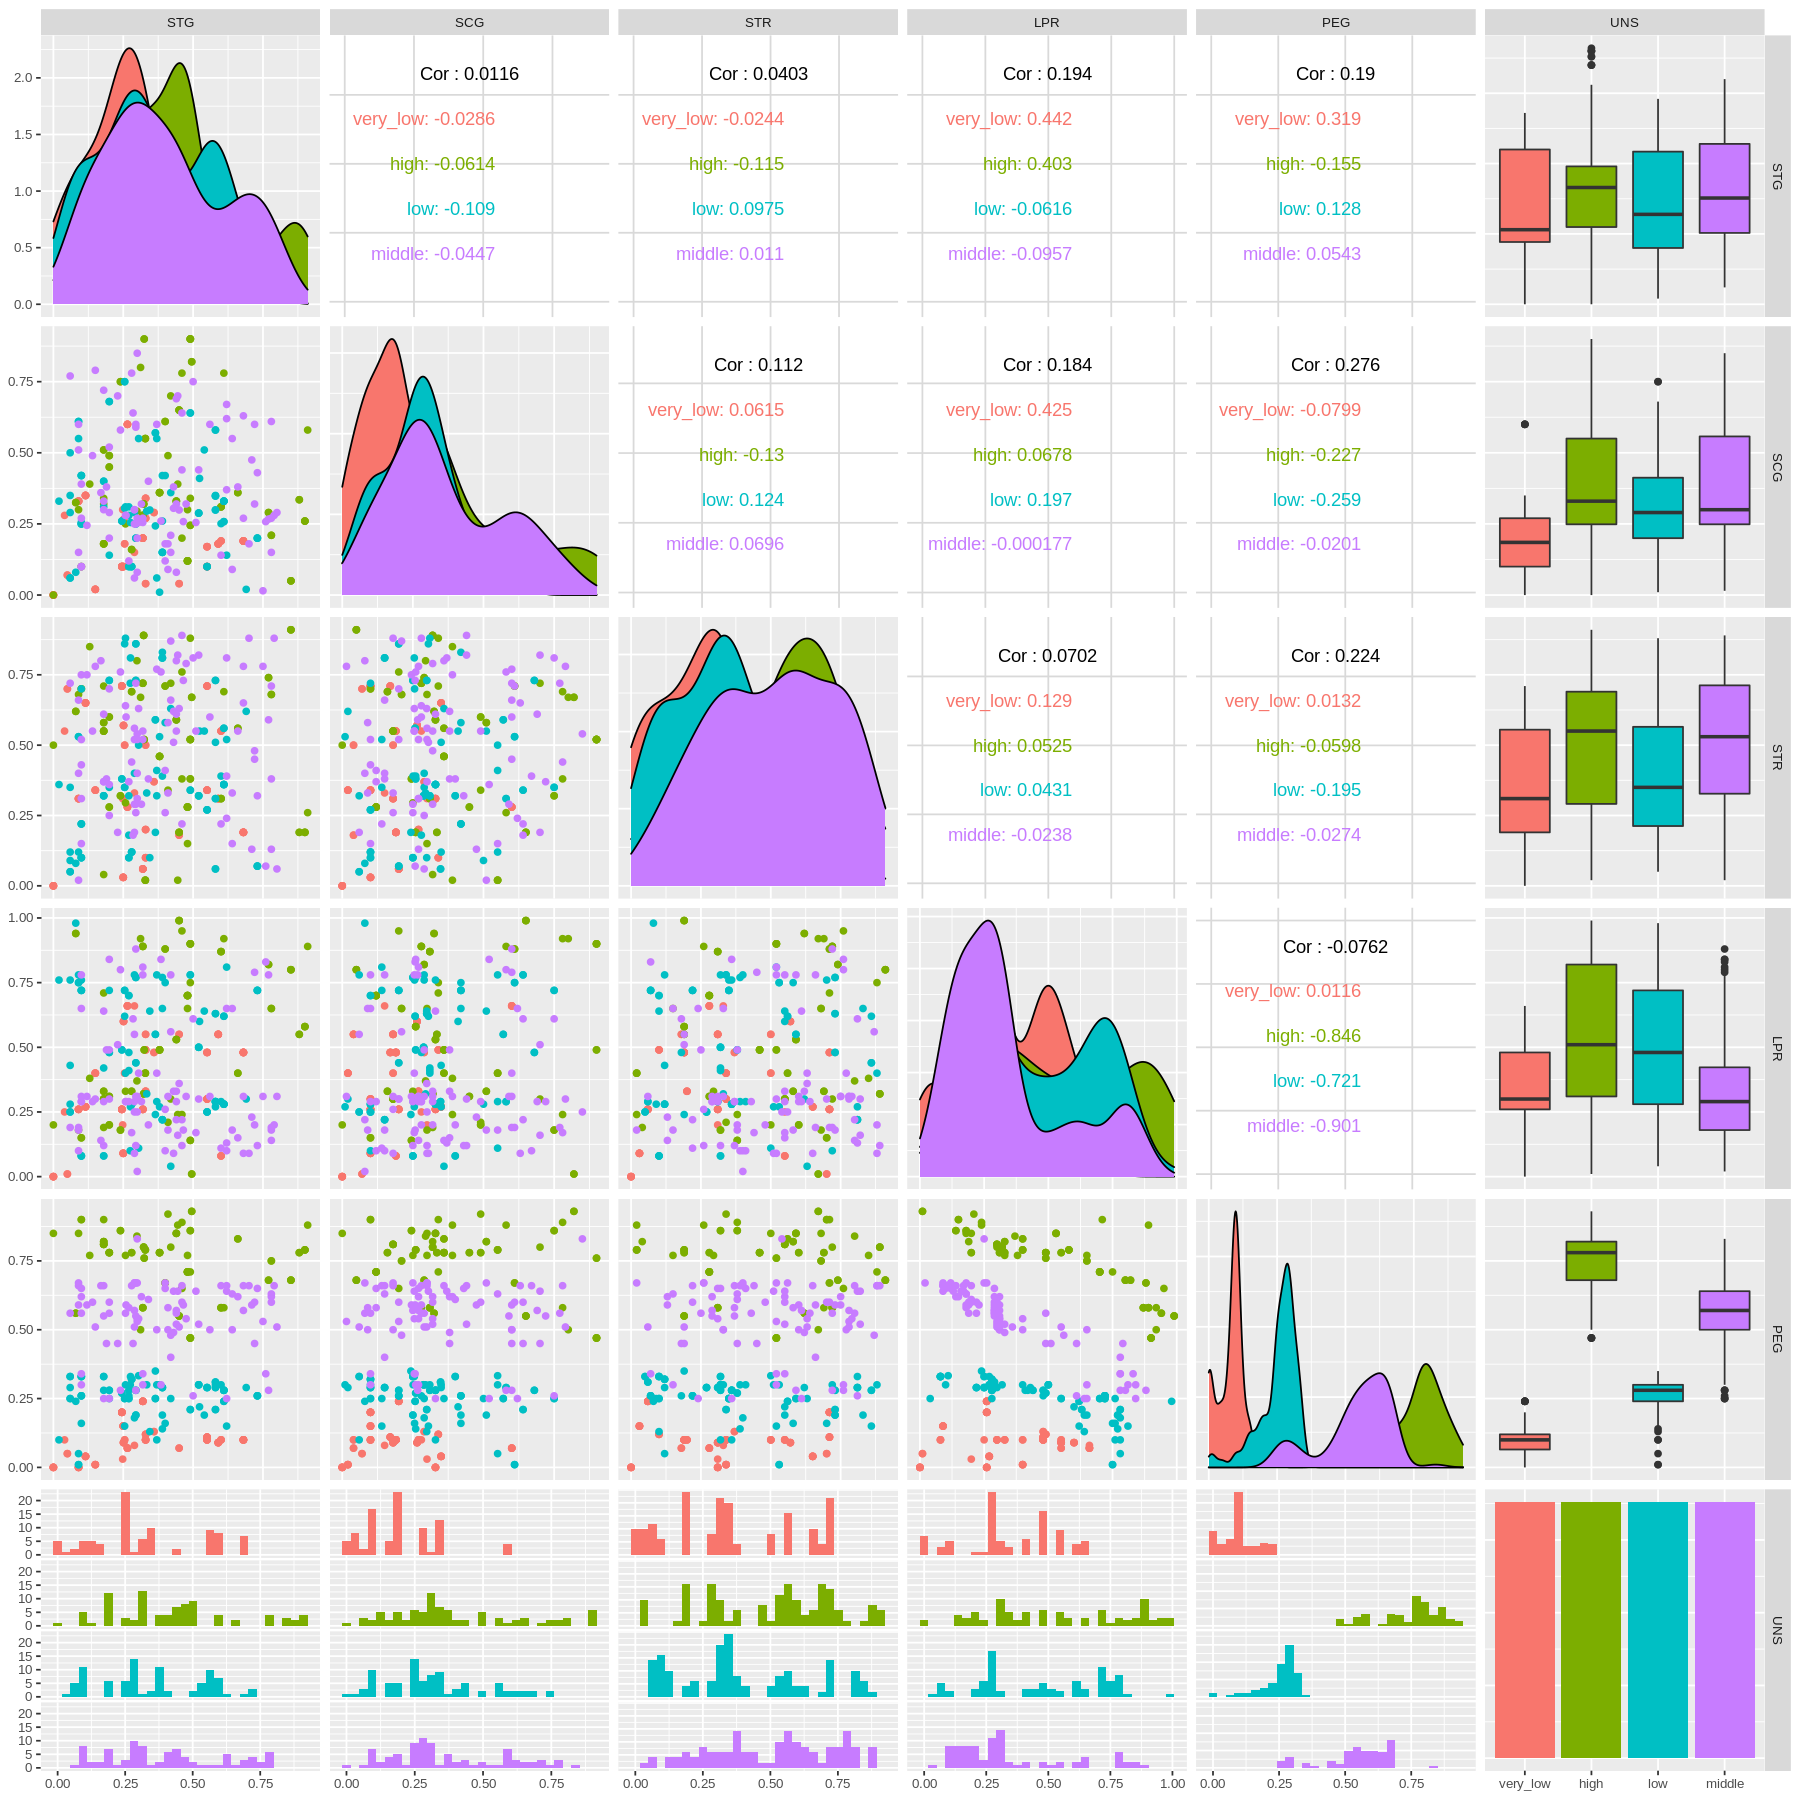

In [145]:
options(repr.plot.width = 15, repr.plot.height = 15)
knowledge_ggpairs <- upsampled_training %>%
    ggpairs(mapping=ggplot2::aes(colour = UNS)) +
    theme(text = element_text(size = 10))

    
knowledge_ggpairs

Table 5: A ggpairs() matrix of all our variables. <br /> 
UNS category colours are:<br /> 
- Very low: <font color='red'>Red</font> 
- Low: <font color='teal'>Teal</font> 
- Middle: <font color='purple'>Purple</font> 
- High: <font color='green'>Green</font> 

We notice that PEG seems to have a strong impact on the spread of each class of UNS. LPR seems to have an impact as well, but to a lesser extent.

## The Model
We want to classify each user's knowledge level based on their domain dependant data for each subject/concept. To do this, we will use a KNN classification model to classify UNS. We will need to evaluate the accuracy of our model on our training data for different K-values with cross-validation, and then on our testing data before it is ready to classify a new user's knowledge. 

From the above GGpairs plot, we think PEG and LPR will have the most success as predictors for UNS. Logically speaking, it makes the most sense that exam scores would classify the knowledge level of a student best as well. To be sure, we will methodically check each combination of predictors accuracy to see confirm this. 
<br /> 
<br /> **The code below runs a model with each subset of predictors and evaluates the model's cross validation accuracy. We will choose the subset of predictors with the highest accuracy below. The code may take some time to run, as it is iterating through possible combinations.**

In [146]:
# names <- colnames(upsampled_training %>% select(-UNS))

# knowledge_formula <- paste("UNS", "~", paste(names, collapse="+"))
# knowledge_formula

# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# predictor_spec <- nearest_neighbor(weight_func = "rectangular",
#                                   neighbors = tune()) %>%
#     set_engine("kknn") %>%
#     set_mode("classification")

# knowledge_vfold <- vfold_cv(upsampled_training, v = 5, strata = UNS)

# n_total <- length(names)

# selected <- c()

# for (i in 1:n_total) {
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))
        
        
        
#         knowledge_recipe <- recipe(as.formula(model_string),
#                                   data = upsampled_training)
        
        
        
#         acc <- workflow() %>%
#             add_recipe(knowledge_recipe) %>%
#             add_model(predictor_spec) %>%
#             tune_grid(resamples = knowledge_vfold, grid = 10) %>%
#             collect_metrics() %>%
#             filter(.metric == "accuracy") %>%
#             summarize(mx = max(mean))
#         acc <- acc$mx %>% unlist()
        
        
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies %>% 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]    
    
# }

# accuracies


*Table 6: The cross-validation accuracies of 5 predictor subsets*

PEG and LPR have the highest accuracy, which matches what we hypothesized above when looking at our GGpairs matrix. Therefore, we will be using these as our predictors to train our model.

We don't need to split our data, because it came already split as part of the dataset. <br /> 
**The code below calculates the proportion of testing and training data.**

In [147]:
total <- nrow(upsampled_training) + nrow(testing_data)
training_prop <- nrow(upsampled_training)/total
testing_prop <- nrow(testing_data)/total
tibble(training_proportion = training_prop, testing_proportion = testing_prop)

training_proportion,testing_proportion
<dbl>,<dbl>
0.7082495,0.2917505


*Table 7: The proportion split of training/testing data, which is a good ratio for our classifier*

We will now use cross-validation to test for the best value of K to use in our classifier.

neighbors,mean,std_err
<dbl>,<dbl>,<dbl>
1,0.9852941,0.009300817
2,0.9852941,0.009300817
3,0.9826797,0.007077257
4,0.9826797,0.007077257
5,0.9826797,0.007077257
⋮,⋮,⋮
16,0.9547386,0.01181566
17,0.9372549,0.01326803
18,0.9372549,0.01326803


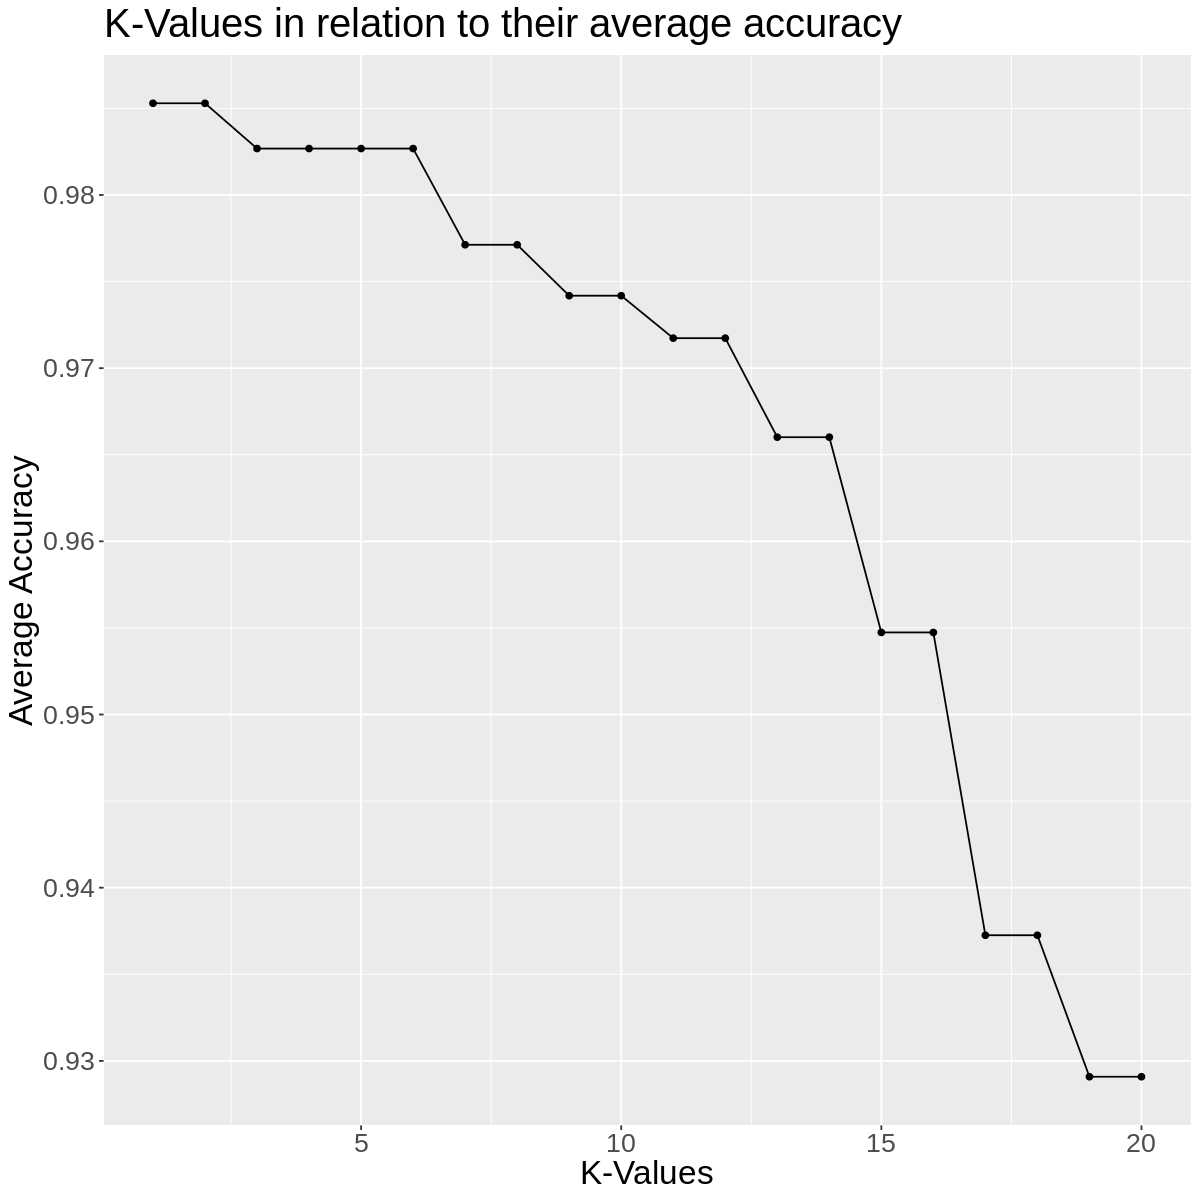

In [148]:

options(repr.plot.width = 10, repr.plot.height = 10)
recipe_2_predictors <- recipe(UNS ~ PEG + LPR, data = upsampled_training)

knowledge_vfold <- vfold_cv(upsampled_training, v = 5, strata = UNS)

k_options_2_predictors <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

spec_2_predictors <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

results_2_predictors <- workflow() %>%
    add_recipe(recipe_2_predictors) %>%
    add_model(spec_2_predictors) %>%
    tune_grid(resamples = knowledge_vfold, grid = k_options_2_predictors) %>%
    collect_metrics()

best_k_2_predictors <- results_2_predictors %>%
    filter(.metric == "accuracy")

best_k_2_predictors_cleaned <- best_k_2_predictors %>%
    select(neighbors, mean, std_err)

best_k_2_predictors_cleaned

accuracy_k <- ggplot(best_k_2_predictors_cleaned, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K-Values", y = "Average Accuracy") +
    ggtitle("K-Values in relation to their average accuracy") +
    theme(text = element_text(size = 20))
accuracy_k

*Fig. 1: A plot of K-values and their average accuracy across the validation sets.*

According to our plot of K-values and their average accuracies, a K value around 5 would yield the highest accuracy for our classifier.

In [149]:
spec_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

spec_fit <- workflow() %>%
    add_recipe(recipe_2_predictors) %>%
    add_model(spec_best_k) %>%
    fit(data = upsampled_training)

predictions <- predict(spec_fit, testing_data) %>%
    bind_cols(testing_data)

predictions



prediction_accuracy <- predictions %>%
    metrics(truth = UNS, estimate = .pred_class)

prediction_accuracy

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
very_low,0.00,0.10,0.50,0.26,0.05,very_low
very_low,0.05,0.05,0.55,0.60,0.14,low
high,0.08,0.18,0.63,0.60,0.85,high
high,0.20,0.20,0.68,0.67,0.85,high
high,0.22,0.22,0.90,0.30,0.90,high
⋮,⋮,⋮,⋮,⋮,⋮,⋮
high,0.90,0.78,0.62,0.32,0.89,high
high,0.85,0.82,0.66,0.83,0.83,high
low,0.56,0.60,0.77,0.13,0.32,low


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9310345
kap,multiclass,0.9072653


## Expected Outcome and Significance

We expect to find that exam scores are able to accurately classify users into their correct knowledge level. Higher exam scores should coincide with higher knowledge levels.  <br />
<br />
The significance of an accurate knowledge classifier concerns the efficacy of web-based adaptive learning environments. Users being classified as their correct knowledge levels for subjects can signal the learning environment which materials the user needs more work with, and which subjects that the user has already mastered, so learners can get the help they need in areas of improvement. <br />
<br />
Some questions that arise are:   <br />
- Can we weight the predictors so that we can use all the predictors to classify the knowledge level of a user, and will this improve the classifiers accuracy?
- How can a learning environment be optimized to collect as much as the users learning data to be able to accurately classify the user's knowledge level?